<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/Brace_Dance_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRACE Breakdancing
We will use an annotated breakdancing dataset puclish in this GitHub: https://github.com/dmoltisanti/brace.git This repository contains the dataset published with the ECCV 2022 paper "BRACE: The Breakdancing Competition Dataset for Dance Motion Synthesis". We will attempt to train a model that will predict 3 distint breakdancing movements (toprock, powermove and footwork)

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/capstone

/content/drive/MyDrive/Github/capstone


In [ ]:
%ls

brace/  datasets/  images/  __pycache__/  README.md  utilities/


In [ ]:
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 6.7 MB/s eta 0:00:00


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image
import random as python_random
import importlib.util
import sys
import os

In [ ]:
sys.path.insert(0,'/content/drive/MyDrive/Github/capstone/brace/utils/')
import keypoints_angles
from keypoints_angles import body_parts, calculate_angle, calculate_angle_to_horizontal, calculate_hand_to_floor_distance, calculate_head_position
from keypoints_angles import calculate_head_to_floor_distance, calculate_leg_angles, calculate_mean_angles, calculate_mean_distance
from keypoints_angles import calculate_mean_hand_distance, calculate_mean_leg_angles, extract_angles_from_dataset, extract_hand_to_floor_distances
from keypoints_angles import extract_head_to_floor_distances, extract_horizontal_angles_from_df, plot_hand_distance_3x2_with_category_names
from keypoints_angles import plot_head_to_floor_histograms, plot_hip_knee_floor, plot_hip_leg_angle, angles_distance_segments

In [ ]:
#CNN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import RandomSearch
#dimensionality reduction and clustering
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Hyper parameter tuning
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Dropout
from tensorflow.keras.models import Model
from kerastuner import HyperModel
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform
import shutil
from tensorflow.keras.callbacks import TensorBoard
import datetime


Set random seed for reproductivity

In [ ]:
def reset_random_seeds():
   np.random.seed(42)
   python_random.seed(42)
   tf.random.set_seed(42)
   import os
   os.environ['PYTHONHASHSEED'] = '0'

reset_random_seeds()

# Disable all GPUs
tf.config.set_visible_devices([], 'GPU')


In [ ]:
df_body_parts = pd.DataFrame(list(body_parts().keys()), index=body_parts().values(), columns=['bodyParts'])
df_body_parts

,bodyParts
0,Nose
1,Left Eye
2,Right Eye
3,Left Ear
4,Right Ear
5,Left Shoulder
6,Right Shoulder
7,Left Elbow
8,Right Elbow
9,Left Wrist


In [ ]:
#uncomment to see all functions within key angles
sys.path.append('./brace/utils')
import inspect
import keypoints_angles
function_list = [o for o in dir(keypoints_angles) if inspect.isfunction(getattr(keypoints_angles, o))]
print(function_list)

['angles_distance_segments', 'body_parts', 'calculate_angle', 'calculate_angle_to_horizontal', 'calculate_hand_to_floor_distance', 'calculate_head_position', 'calculate_head_to_floor_distance', 'calculate_leg_angles', 'calculate_mean_angles', 'calculate_mean_distance', 'calculate_mean_hand_distance', 'calculate_mean_leg_angles', 'extract_angles_from_dataset', 'extract_hand_to_floor_distances', 'extract_head_to_floor_distances', 'extract_horizontal_angles_from_df', 'plot_hand_distance_3x2_with_category_names', 'plot_head_to_floor_histograms', 'plot_hip_knee_floor', 'plot_hip_leg_angle']


Load Dataset


The commented code below processes the keypoints files dowloaded from Brace breakdancing, using code provided in with the BRACE Breaking GitHub. For comvenience a fully processes dataset is provided.

In [ ]:
# @title
###### Run to obtain the dataset, this takes a long time after the dataset and it will only be needed if you did not have  DataClips, Labels, Segments, sequences saved already.
# # Specify the path to your module
# module_path = '/content/drive/MyDrive/Github/capstone/brace/utils/bracedataset.py'
# module_name = 'bracedataset'
# # Load the module dynamically
# spec = importlib.util.spec_from_file_location(module_name, module_path)
# module = importlib.util.module_from_spec(spec)
# sys.modules[module_name] = module
# spec.loader.exec_module(module)

#load keypoints segments
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# #get max length of the keypoints
# max_length = max(seq.shape[0] for seq in dataClips)

# #pad tensor so they are of the same lenght
# dataClips_tensors=[np.pad(array.astype(np.float32), ((0, max_length - array.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=0) for array in dataClips]
# dataClips_tensors=torch.tensor(dataClips_tensors)
# #convert labels to tensors
# label_tensors = np.array(encoded_categories)
# label_tensors=torch.tensor(label_tensors)
# ##SPLIT SET FOR REPRODUCTIVITY
# dataset = TensorDataset(dataClips_tensors, label_tensors)
# # Set seed for reproducibility
# torch.manual_seed(42)

# # Determine split sizes
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(f"Training set size: {len(train_dataset)}")
# print(f"Testing set size: {len(test_dataset)}")
# # Save the TensorDataset
# with open('tensor_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

# # Save the Subset
# with open('train_subset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)
# with open('test_subset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

Load processed dataClips, labels and names.

In [ ]:
#load segment
segments= pd.read_csv(Path('./brace/annotations/segments.csv'))
# Load the TensorDataset
with open('./brace/dataset/dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('./brace/dataset/labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('./brace/dataset/names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]
#get flatted clips
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

In [ ]:
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']

# Dimensionality Reduction
The dataset contains 1352 clips with segments ranging from 105-1200 eah segment contains a 17X2 numpy. We will be conducting dimensionallty reduction to visualize our data.

In [ ]:
dtw_means=[]
for i in dataClips:
    data=i
    data_flattened = [clip.reshape(clip.shape[0], -1) for clip in data]
    distance_matrix = dtw.distance_matrix_fast(data_flattened)
    mean_dist=distance_matrix.mean()
    dtw_means.append(mean_dist)

cluster_df=features[['seq_idx', 'frames']].copy()
cluster_df['dtw']= pd.Series(dtw_means)
cluster_df.shape

(1352, 3)

# Clustering with dynamic Time Warping.
"In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed. For instance, similarities in walking could be detected using DTW, even if one person was walking faster than the other, or if there were accelerations and decelerations during the course of an observation. DTW has been applied to temporal sequences of video, audio, and graphics data", from https://en.wikipedia.org/wiki/Dynamic_time_warping.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


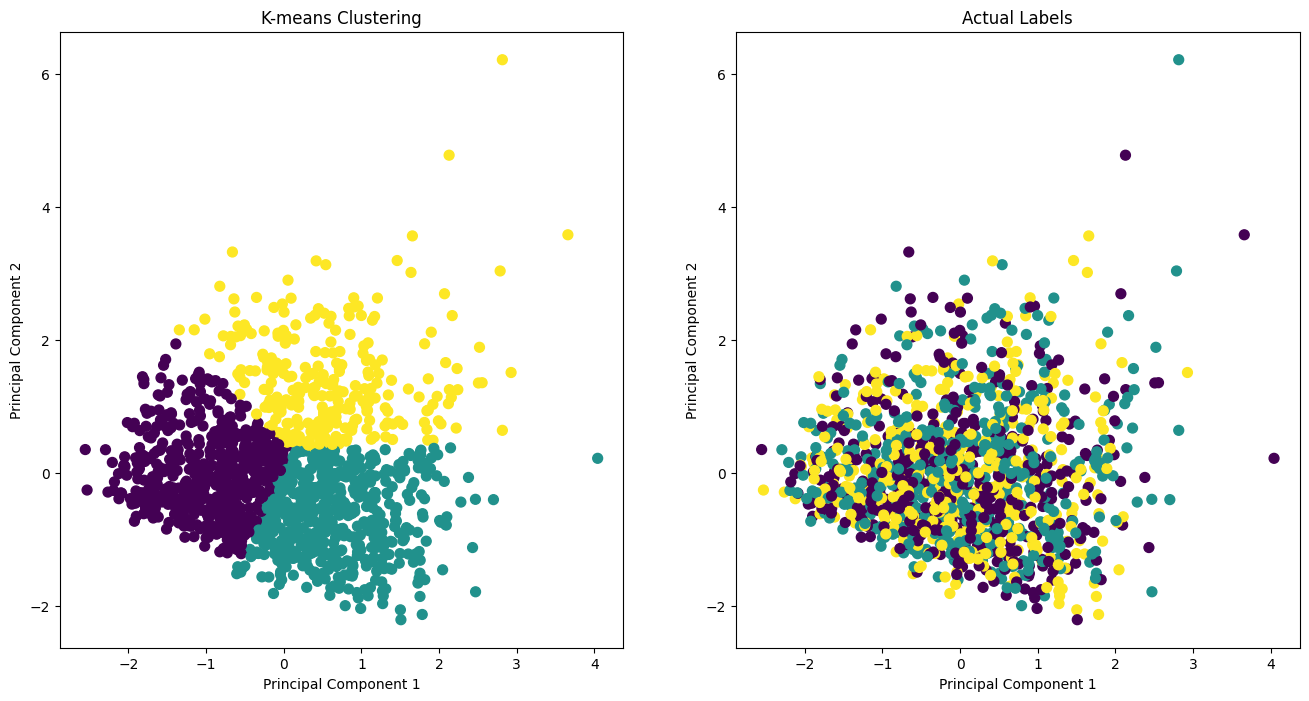

In [ ]:
#PCA dimensionality reduction of dataClips processed with dynamic time warping.
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(cluster_df)
pca = PCA(n_components=2)
clusters_pca = pca.fit_transform(clusters_scaled)
pca_df = pd.DataFrame(data=clusters_pca, columns=['Principal Component 1', 'Principal Component 2'])

#K-means
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['ActualLabels'] = encoded_categories

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means Cluster Plot
ax[0].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax[0].set_title('K-means Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Actual Labels Plot
ax[1].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['ActualLabels'], cmap='viridis', s=50)
ax[1].set_title('Actual Labels')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.show()

Clustering does not perform very well, since we are not able to accurate separate the different labels.

In [ ]:
category_to_int

{'powermove': 0, 'toprock': 1, 'footwork': 2}

# Perform Analysis with CNN-LSTM
The CNN Long Short-Term Memory Network or CNN LSTM for short is an LSTM architecture specifically designed for sequence prediction problems with spatial inputs, like images or videos. We will try to predict the following movements.
Toprock-      Powermove- Footwork
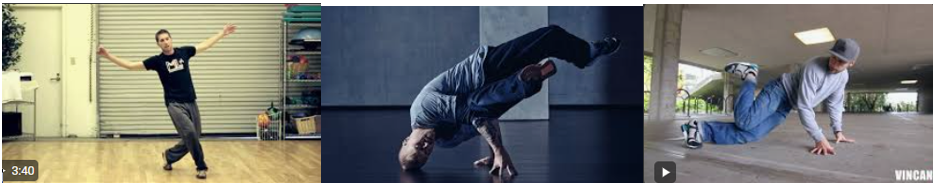

In [ ]:
### LSTM MODEL WITH dense and drop out
reset_random_seeds() # random seed


padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2]), kernel_initializer=GlorotUniform(seed=42)),
    Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 16s 495ms/step - loss: 1.0990 - accuracy: 0.3426 - val_loss: 1.1024 - val_accuracy: 0.2949
Epoch 2/1

In [ ]:
# test
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 2s 171ms/step - loss: 1.0981 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


Model accuracy is too low, We will try Time distributed NN anoted model to handle video as a time series. Like our clips. https://keras.io/api/layers/recurrent_layers/time_distributed/

In [ ]:
####### Time Distributed CNN
#train test set
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

input_shape = (padded_clips.shape[1], 17, 2, 1)

model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu', kernel_initializer=GlorotUniform(seed=42)), input_shape=(1280, 34, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),

    LSTM(50, kernel_initializer=GlorotUniform(seed=42), recurrent_initializer=GlorotUniform(seed=42)),
    Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1280, 32, 32)      128       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1280, 16, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1280, 512)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 50)                112600    
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                      

In [ ]:
# test
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 8s 865ms/step - loss: 1.0977 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


Accuracy continues to be too low. since our videos are of different lenght we used padding to make them all the same lenght, we will try a different approach on the padding to see if we obtain a better performance. Below we plotted the sequence lenght to determine the 90th percentile lenght.

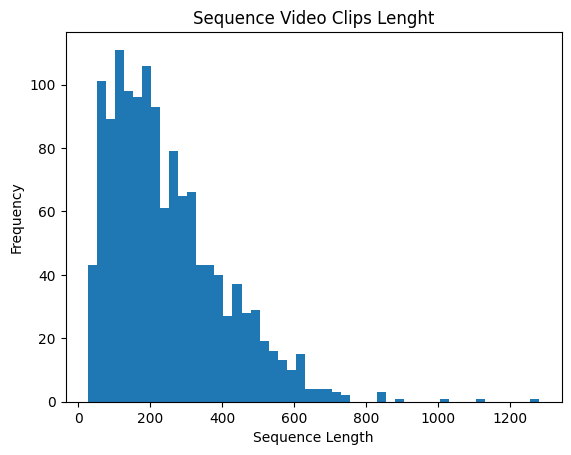

Max Lenght 90th percentile: 471.9000000000001


In [ ]:
sequence_lengths = [len(seq) for seq in flattened_clips]

plt.hist(sequence_lengths, bins=50)
plt.title('Sequence Video Clips Lenght')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maxlen based on the distribution, for example, the 90th percentile
maxlen = np.percentile(sequence_lengths, 90)
print("Max Lenght 90th percentile:",maxlen)

Based on that we will pad the images only to the 90th percentile lenght truncating clips longer than that at the begining of the clip. The reason we chose to clip the begining if the clip is to try to eliminated introductory images or "posturing" that often takes place between breakdancing round battles. We will try again with the LSTM model we used first

# Baseline Model w/ 90th percetile padding and truncating at the begining of the clip is needed

In [ ]:
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2]), kernel_initializer=GlorotUniform(seed=42)),
    Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42)),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=6, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                17000     
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
27/27 [==============================] - 8s 201ms/step - loss: 1.1098 - accuracy: 0.3264 - val_loss: 1.0951 - val_accuracy: 0.3226
Epoch 2/6

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 1s 116ms/step - loss: 0.5287 - accuracy: 0.7159
Test accuracy: 0.7158671617507935


We observe a large improvement on accuracy, we will plot the training history

9/9 [==============================] - 0s 51ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        98
           1       0.99      0.96      0.97        98
           2       0.40      0.03      0.05        75

    accuracy                           0.72       271
   macro avg       0.65      0.66      0.58       271
weighted avg       0.68      0.72      0.63       271



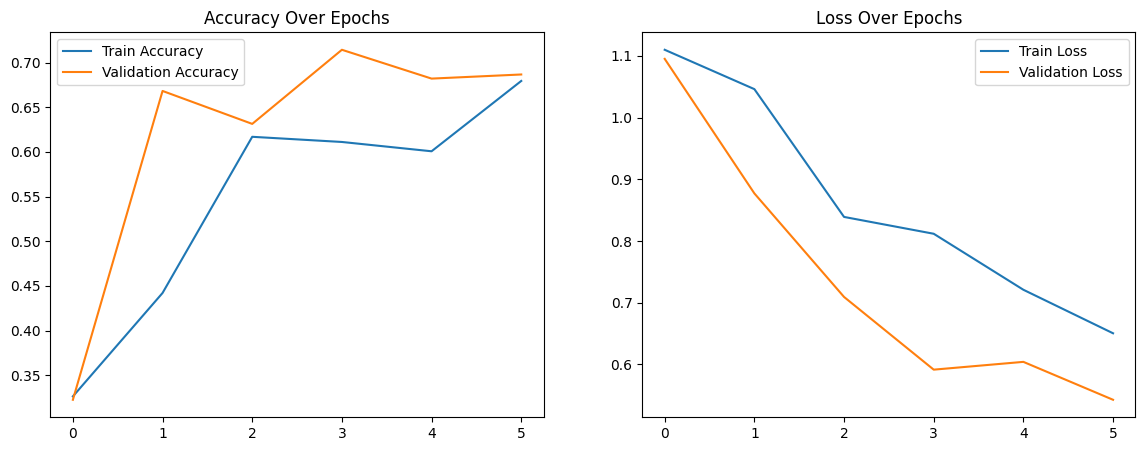

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)


# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

# We will try to augment out data by introducing additional features.
In addition to the key points per each clip, we will include the sequence index and number of frames. This model requires to process keypoints and additional data in two separate branches and combine the classifications weights. We will be using am LSTM model, since it is 10X faster to train that Time Distributed model, and we obtained similar results when training with keypoint only

In [ ]:
##Prepocess additional features to augment our model
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('frames', OneHotEncoder(), ['frames'])
    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'frames']])
features_preprocessed = features_preprocessed.toarray()

In [ ]:
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')

X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50, kernel_initializer=GlorotUniform(seed=42))(keypoint_input)
keypoint_model = Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42))(keypoint_model)

additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu', kernel_initializer=GlorotUniform(seed=42))(additional_features_input)

combined = concatenate([keypoint_model, features_model])
combined = Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42))(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))(combined)

model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

# Train the model
history = model.fit([X_train_clips, X_train_features], y_train_onehot, epochs=8, batch_size=32, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 471, 34)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_3 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 505)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 0s 49ms/step - loss: 0.4726 - accuracy: 0.7085
Test Loss: 0.47257348895072937
Test Accuracy: 0.7084870934486389


9/9 [==============================] - 1s 48ms/step
              precision    recall  f1-score   support

           0       0.61      0.64      0.62        98
           1       0.97      1.00      0.98        98
           2       0.47      0.41      0.44        75

    accuracy                           0.71       271
   macro avg       0.68      0.69      0.68       271
weighted avg       0.70      0.71      0.70       271



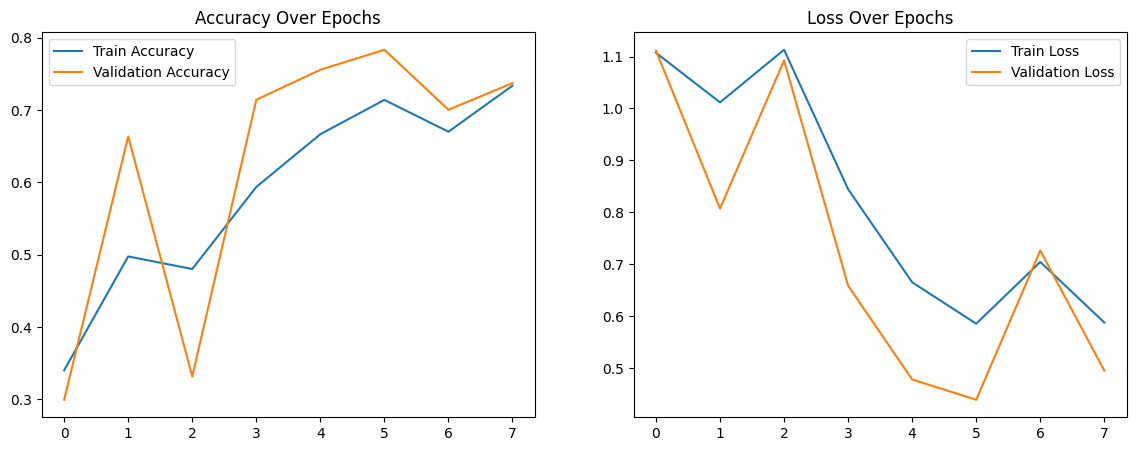

In [ ]:
# Predictions
y_pred = model.predict([X_test_clips, X_test_features])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)


# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

We did not see in improvement in accuracy by adding sequence and frame lenght, next we will experiment with other features extraction in order to improve our results.

# Additional Feature Extraction
Considering that the three movements that we try to predict have different distributions (see our notebook Brace angle analysis). We will create additional features to train a model by calculating the followting for all clips at each segment.


*   Hip-Knee-Ankle angle
*   Hip-Knee angle
*   Distance from head to floor
*   Distance from wrists to floot

In [ ]:
hip_knee_ankle_angles= angles_distance_segments(flattened_clips)

# CNN with drop out layers and reduced lenght padding

In [ ]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
labels_categorical = to_categorical(encoded_categories)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_categorical, test_size=0.2, random_state=42)

# Model creation
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, 7), kernel_initializer=GlorotUniform(seed=42), recurrent_initializer=GlorotUniform(seed=42)),
    Dropout(0.2),
    LSTM(64, kernel_initializer=GlorotUniform(seed=42), recurrent_initializer=GlorotUniform(seed=42)),
    Dropout(0.2),
    Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Training
history =model.fit(X_train, y_train, epochs=8, validation_split=0.1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 128)         69632     
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 119235 (465.76 KB)
Trainable params: 119235 (465.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
31/3

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 2s 245ms/step - loss: 0.4725 - accuracy: 0.7417
Test accuracy: 0.7416974306106567


9/9 [==============================] - 3s 277ms/step
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        98
           1       0.96      0.96      0.96        98
           2       0.55      0.55      0.55        75

    accuracy                           0.74       271
   macro avg       0.73      0.73      0.73       271
weighted avg       0.74      0.74      0.74       271



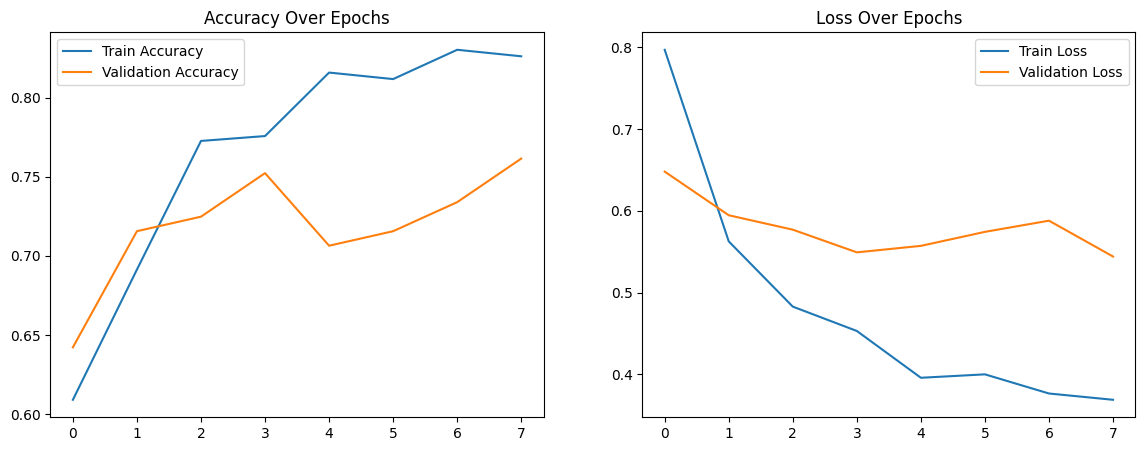

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)


# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

# Combine sequence numbers, frame lenght with distance/angles dataset
We will attempt to combines these to improve out model performance. Ref. https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://www.analyticsvidhya.com/blog/2021/08/hyperparameter-tuning-of-neural-networks-using-keras-tuner/

In [ ]:
# Padding sequences
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
padded_angles = pad_sequences(hip_knee_ankle_angles, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')

# Normalize angles
n_samples = padded_angles.shape[0]
n_features = padded_angles.shape[1] * padded_angles.shape[2]
flattened_angles = padded_angles.reshape(n_samples, n_features)
scaler = StandardScaler()
X_temp_angles, X_test_angles, _, _ = train_test_split(flattened_angles, encoded_categories, test_size=0.2, random_state=42)
scaler.fit(X_temp_angles)

# Transform both training and testing data
X_train_angles_norm = scaler.transform(X_temp_angles)
X_test_angles_norm = scaler.transform(X_test_angles)
X_train_angles = X_train_angles_norm.reshape(-1, padded_angles.shape[1], padded_angles.shape[2])
X_test_angles = X_test_angles_norm.reshape(-1, padded_angles.shape[1], padded_angles.shape[2])

encoded_categories_array = np.array(encoded_categories)
labels_onehot = to_categorical(encoded_categories_array, num_classes=3)
X_train_clips, X_test_clips, X_train_features, X_test_features, y_train_onehot, y_test_onehot = train_test_split(
    padded_clips, features_preprocessed, labels_onehot, test_size=0.2, random_state=42, stratify=encoded_categories)



In [ ]:
# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50, kernel_initializer=GlorotUniform(seed=42), recurrent_initializer=GlorotUniform(seed=42))(keypoint_input)
keypoint_model = Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42))(keypoint_model)

# Angles input branch
angles_input = Input(shape=(X_train_angles.shape[1], X_train_angles.shape[2]), name='angles_input')
angles_model = LSTM(50, kernel_initializer=GlorotUniform(seed=42), recurrent_initializer=GlorotUniform(seed=42))(angles_input)
angles_model = Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42))(angles_model)

# Additional features input branch
features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu', kernel_initializer=GlorotUniform(seed=42))(features_input)

# Concatenate the outputs of the three branches
combined = concatenate([keypoint_model, angles_model, features_model])
combined = Dense(100, activation='relu', kernel_initializer=GlorotUniform(seed=42))(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax', kernel_initializer=GlorotUniform(seed=42))(combined)

# Building the model
model = Model(inputs=[keypoint_input, angles_input, features_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model with controlled randomness
history = model.fit(
    [X_train_clips, X_train_angles, X_train_features], y_train_onehot,
    epochs=7, batch_size=32,
    validation_split=0.2
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 471, 34)]            0         []                            
 )                                                                                                
                                                                                                  
 angles_input (InputLayer)   [(None, 471, 7)]             0         []                            
                                                                                                  
 lstm_10 (LSTM)              (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 lstm_11 (LSTM)              (None, 50)                   11600     ['angles_input[0][0]']  

In [ ]:
# Evaluation
loss, accuracy = model.evaluate([X_test_clips, X_test_angles, X_test_features], y_test_onehot)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 1s 141ms/step - loss: 0.5765 - accuracy: 0.7897
Test accuracy: 0.7896679043769836


9/9 [==============================] - 2s 84ms/step
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        85
           1       0.99      0.87      0.93        93
           2       0.75      0.74      0.75        93

    accuracy                           0.79       271
   macro avg       0.80      0.79      0.79       271
weighted avg       0.80      0.79      0.79       271



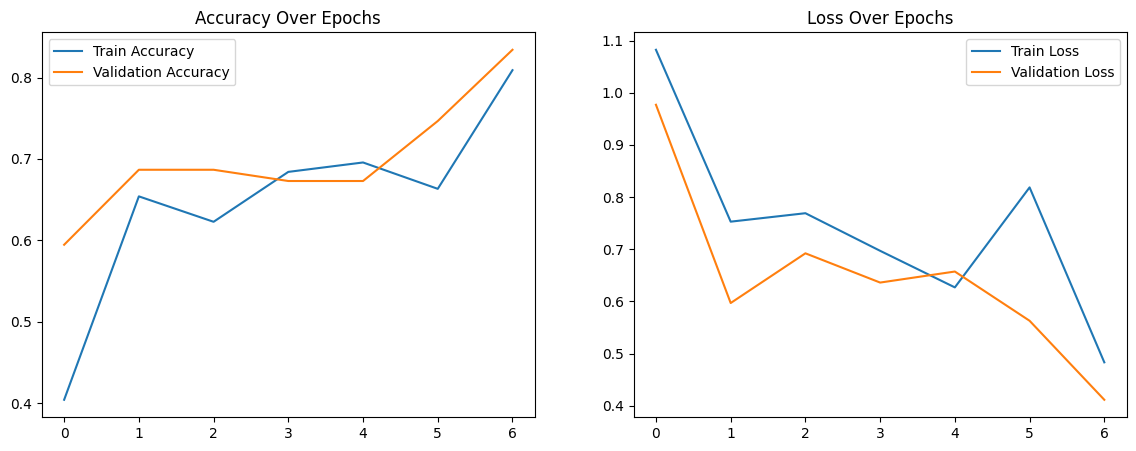

In [ ]:
# Predictions
y_pred = model.predict([X_test_clips, X_test_angles, X_test_features])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

By combining the keypoints, additional features and keypoint distance calculations we had an improvement on out model. Next, we will perform hyperparameter tuning to increase the accuracy of our models.